# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_AD1_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for AD1 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_AD1_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [33]:
library(data.table)
library(tidyverse)
library(pecotmr)

In [34]:
setwd("~/data")

In [35]:
##Bonfferroni correction is too strict
# AD1_twas = fread("~/project/image_QTL/twas/multiple_testing/image_AD1_twas_bonff.bonf_corrected.tsv.gz")


In [36]:
AD1_twas = fread("~/project/image_QTL/twas/image_AD1_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [52]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- AD1_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [6]:
head(AD1_twas)
dim(AD1_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD1,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.4604784,0.6451729061,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD1,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.4628714,0.6434565734,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD1,mrash,TRUE,FALSE,0.089177838,6.013310e-09,0.6389774,0.5228376549,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD1,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.4641349,0.6425511004,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD1,enet,TRUE,FALSE,0.007872702,5.201216e-02,-3.5326758,0.0004113766,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD1,lasso,TRUE,FALSE,0.006195072,7.447581e-02,-3.4892189,0.0004844343,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 927133     19

In [64]:
# Strong and reliable TWAS signals:
AD1_twas_filtered <- AD1_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
AD1_block = unique(AD1_twas_filtered$block)

In [65]:
dim(AD1_twas_filtered)

[1] 443  19

In [67]:
most_likely_causal_genes = AD1_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(abs(twas_z), n = 1) 

In [68]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000138175,102714396,101673731,103714397,AC_DeJager_eQTL,image_AD1,bayes_r,TRUE,FALSE,0.02819203,2.346740e-05,-5.154788,2.539182e-07,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
14,ENSG00000151838,59576811,58080000,60600000,AC_DeJager_eQTL,image_AD1,bayes_l,TRUE,FALSE,0.04270906,2.288710e-07,-5.965036,2.445800e-09,eQTL,chr14_58669547_61213190,chr14_58669547_61213190,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr14_58669547_61213190.twas.tsv.gz
16,ENSG00000157315,69351785,66880000,71160000,AC_DeJager_eQTL,image_AD1,enet,TRUE,FALSE,0.03231437,6.299037e-06,-4.774097,1.805153e-06,eQTL,chr16_68398988_70662193,chr16_68398988_70662193,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_68398988_70662193.twas.tsv.gz
17,ENSG00000186868,45894526,42560000,47028334,AC_DeJager_eQTL,image_AD1,bayes_r,TRUE,FALSE,0.01088200,6.310740e-03,5.010780,5.420980e-07,eQTL,chr17_45383525_50162864,chr17_45383525_50162864,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr17_45383525_50162864.twas.tsv.gz
20,ENSG00000125965,35454745,34433347,37080000,AC_DeJager_eQTL,image_AD1,mrash,TRUE,FALSE,0.03551907,2.267474e-06,-4.796997,1.610617e-06,eQTL,chr20_32060775_36429279,chr20_32060775_36429279,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr20_32060775_36429279.twas.tsv.gz
2,ENSG00000163171,37738467,36641882,39240000,AC_DeJager_eQTL,image_AD1,bayes_l,TRUE,FALSE,0.06346084,2.940073e-10,4.913180,8.961082e-07,eQTL,chr2_37591842_40054824,chr2_37591842_40054824,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr2_37591842_40054824.twas.tsv.gz


[1] 132  19

In [69]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 132

In [70]:
AD1_gene = unique(most_likely_causal_genes$molecular_id)

In [71]:
image_AD1_gene_list <- AD1_twas |> 
  dplyr::filter(molecular_id %in% AD1_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [72]:
dim(image_AD1_gene_list)

[1] 66  4

In [73]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [74]:
image_AD1_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_AD1")) |> dplyr::select(-strand,-event_ID)
                                        

In [75]:
image_AD1_gene = bind_rows(image_AD1_gene_list, image_AD1_QTL_gene)

In [76]:
fwrite(image_AD1_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD1_gene_list.tsv", sep = '\t')

### image_AD1_QTL list

In [77]:

library(clusterProfiler)
library(org.Hs.eg.db)


In [78]:
image_AD1_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD1_gene_list.tsv")
AD1_gene = image_AD1_gene |> filter(gene_name == '')  |> pull(molecular_id)

In [79]:
AD1_sig_gene_ego <- enrichGO(
  gene          = unique(image_AD1_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [80]:
head(AD1_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0019896,GO:0019896,axonal transport of mitochondrion,3/64,20/21261,2.859134e-05,0.03369257,0.02980701,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:0034643,GO:0034643,"establishment of mitochondrion localization, microtubule-mediated",3/64,28/21261,8.076156e-05,0.03369257,0.02980701,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:0047497,GO:0047497,mitochondrion transport along microtubule,3/64,28/21261,8.076156e-05,0.03369257,0.02980701,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:1904357,GO:1904357,negative regulation of telomere maintenance via telomere lengthening,3/64,32/21261,1.212301e-04,0.03369257,0.02980701,ENSG00000107960/ENSG00000173273/ENSG00000258724,3
GO:0051654,GO:0051654,establishment of mitochondrion localization,3/64,33/21261,1.330670e-04,0.03369257,0.02980701,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:0033044,GO:0033044,regulation of chromosome organization,6/64,280/21261,1.954289e-04,0.04123549,0.03648006,ENSG00000107960/ENSG00000100811/ENSG00000186868/ENSG00000173273/ENSG00000173473/ENSG00000258724,6
GO:0032205,GO:0032205,negative regulation of telomere maintenance,3/64,40/21261,2.373705e-04,0.04293014,0.03797927,ENSG00000107960/ENSG00000173273/ENSG00000258724,3
GO:0018023,GO:0018023,peptidyl-lysine trimethylation,2/64,10/21261,3.952113e-04,0.06254219,0.05532958,ENSG00000181555/ENSG00000145002,2
GO:0051646,GO:0051646,mitochondrion localization,3/64,53/21261,5.473446e-04,0.07699314,0.06811399,ENSG00000131966/ENSG00000186868/ENSG00000186094,3


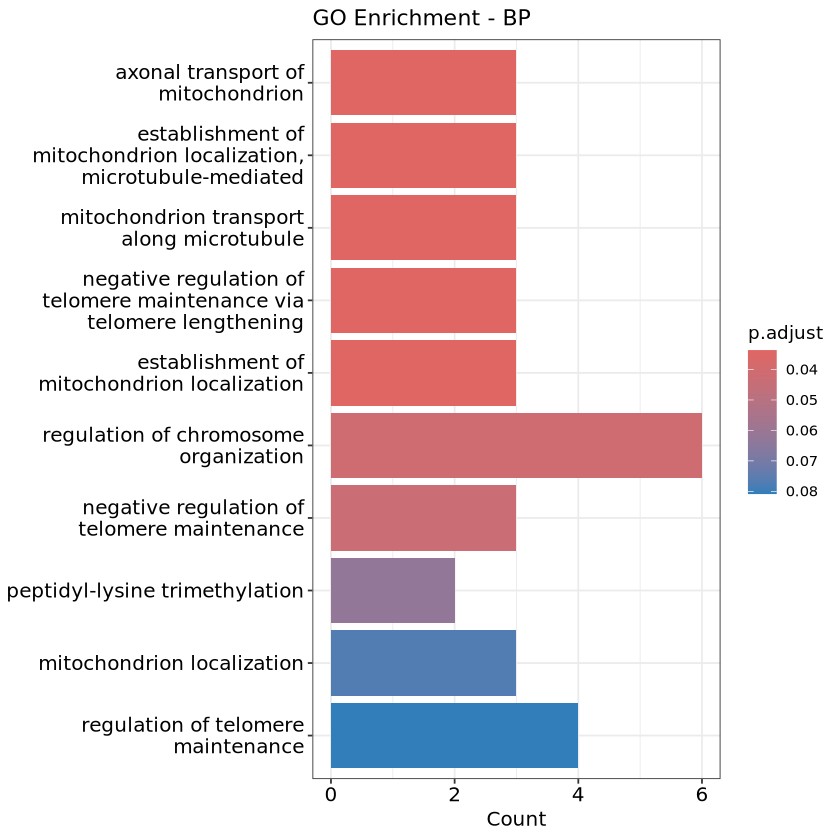

In [81]:
barplot(AD1_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [82]:
AD1_sig_gene_ego_cc <- enrichGO(
  gene          = image_AD1_gene$molecular_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [83]:
head(AD1_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:1904115,GO:1904115,axon cytoplasm,3/64,66/22568,0.0008762394,0.07645438,0.06187310,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:0032838,GO:0032838,plasma membrane bounded cell projection cytoplasm,5/64,263/22568,0.0009006410,0.07645438,0.06187310,ENSG00000131966/ENSG00000186868/ENSG00000186094/ENSG00000183638/ENSG00000047849,5
GO:0099568,GO:0099568,cytoplasmic region,5/64,301/22568,0.0016368478,0.07645438,0.06187310,ENSG00000131966/ENSG00000186868/ENSG00000186094/ENSG00000183638/ENSG00000047849,5
GO:0120111,GO:0120111,neuron projection cytoplasm,3/64,92/22568,0.0022820181,0.07645438,0.06187310,ENSG00000131966/ENSG00000186868/ENSG00000186094,3
GO:0030673,GO:0030673,axolemma,2/64,26/22568,0.0024624717,0.07645438,0.06187310,ENSG00000186868/ENSG00000029534,2
GO:0000781,GO:0000781,"chromosome, telomeric region",4/64,199/22568,0.0024662704,0.07645438,0.06187310,ENSG00000107960/ENSG00000173273/ENSG00000094916/ENSG00000258724,4
GO:0101002,GO:0101002,ficolin-1-rich granule,4/64,235/22568,0.0044672805,0.11870203,0.09606333,ENSG00000131966/ENSG00000160796/ENSG00000164733/ENSG00000178035,4
GO:0097431,GO:0097431,mitotic spindle pole,2/64,40/22568,0.0057610667,0.13394480,0.10839902,ENSG00000066629/ENSG00000173273,2
GO:0032391,GO:0032391,photoreceptor connecting cilium,2/64,45/22568,0.0072459290,0.14974920,0.12118922,ENSG00000138175/ENSG00000183638,2


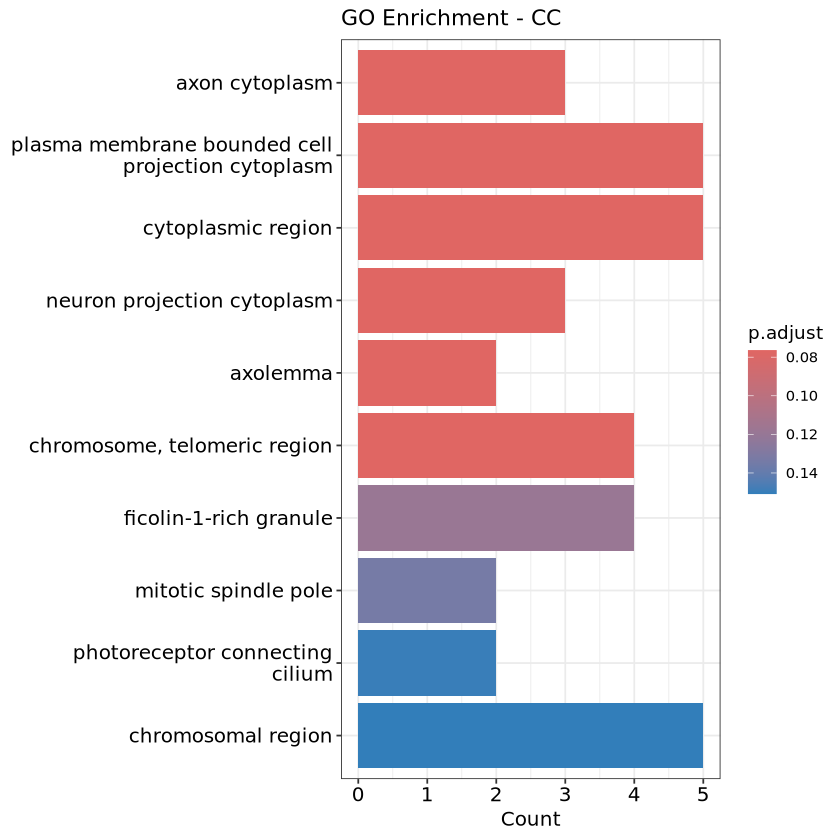

In [84]:
barplot(AD1_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [85]:
image_AD1_sig_gene_ego_mf <- enrichGO(
  gene          = image_AD1_gene$molecular_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [86]:
head(image_AD1_sig_gene_ego_mf, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0015631,GO:0015631,tubulin binding,6/60,397/21059,0.0009168468,0.1415140,0.1259182,ENSG00000138175/ENSG00000066629/ENSG00000186868/ENSG00000186094/ENSG00000181555/ENSG00000047849,6
GO:0019903,GO:0019903,protein phosphatase binding,4/60,175/21059,0.0015636902,0.1415140,0.1259182,ENSG00000186868/ENSG00000104643/ENSG00000147324/ENSG00000029534,4
GO:0051721,GO:0051721,protein phosphatase 2A binding,2/60,33/21059,0.0039820810,0.1895866,0.1686929,ENSG00000186868/ENSG00000147324,2
GO:0019902,GO:0019902,phosphatase binding,4/60,230/21059,0.0041897582,0.1895866,0.1686929,ENSG00000186868/ENSG00000104643/ENSG00000147324/ENSG00000029534,4
GO:0000217,GO:0000217,DNA secondary structure binding,2/60,41/21059,0.0060946329,0.2206257,0.1963113,ENSG00000100811/ENSG00000186868,2
GO:0008017,GO:0008017,microtubule binding,4/60,289/21059,0.0092771418,0.2765923,0.2461101,ENSG00000138175/ENSG00000066629/ENSG00000186868/ENSG00000047849,4
GO:0016279,GO:0016279,protein-lysine N-methyltransferase activity,2/60,69/21059,0.0165708011,0.2765923,0.2461101,ENSG00000181555/ENSG00000145002,2
GO:0016278,GO:0016278,lysine N-methyltransferase activity,2/60,70/21059,0.0170272702,0.2765923,0.2461101,ENSG00000181555/ENSG00000145002,2
GO:1901981,GO:1901981,phosphatidylinositol phosphate binding,3/60,193/21059,0.0176950583,0.2765923,0.2461101,ENSG00000186868/ENSG00000170633/ENSG00000123329,3


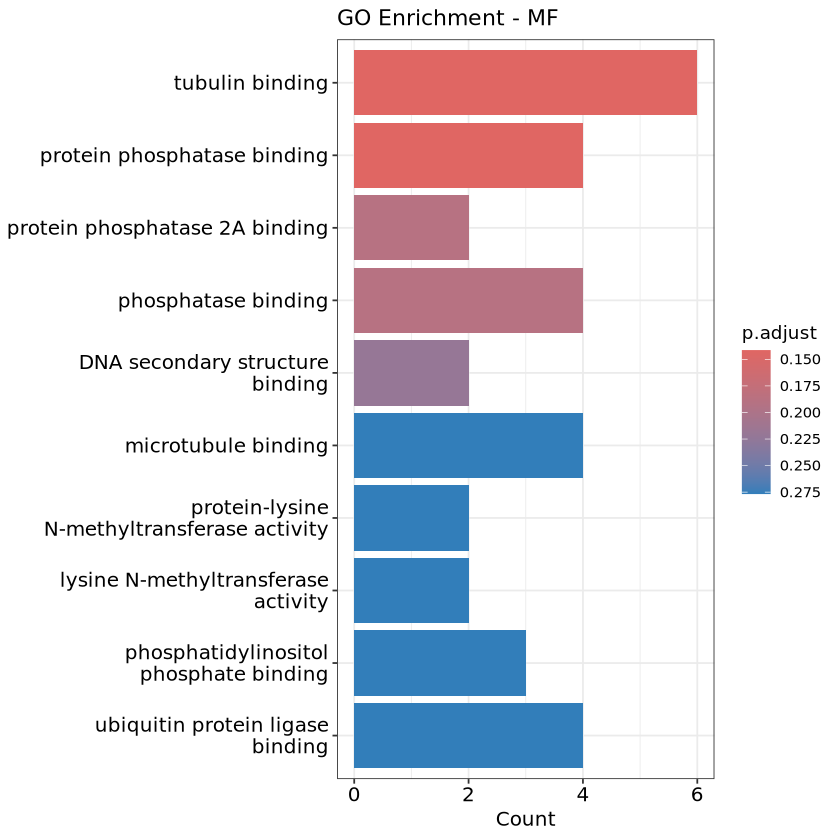

In [87]:
barplot(image_AD1_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [88]:
entrez_ids <- bitr(image_AD1_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(image_AD1_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“1.49% of input gene IDs are fail to map...”


In [89]:
kegg_enrich %>% head(n=20)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,3/26,169/9446,0.01081242,0.4921562,0.4917172,9342/1508/64798,3
hsa03082,Genetic Information Processing,Chromosome,hsa03082,ATP-dependent chromatin remodeling,2/26,117/9446,0.04074344,0.4921562,0.4917172,7528/6599,2
hsa00230,Metabolism,Nucleotide metabolism,hsa00230,Purine metabolism,2/26,128/9446,0.04791421,0.4921562,0.4917172,5151/3615,2
hsa00100,Metabolism,Lipid metabolism,hsa00100,Steroid biosynthesis,1/26,20/9446,0.05368639,0.4921562,0.4917172,2222,1
hsa04130,Genetic Information Processing,"Folding, sorting and degradation",hsa04130,SNARE interactions in vesicular transport,1/26,33/9446,0.08708451,0.4921562,0.4917172,9342,1
hsa04360,Organismal Systems,Development and regeneration,hsa04360,Axon guidance,2/26,184/9446,0.09044623,0.4921562,0.4917172,85464/5364,2
hsa03050,Genetic Information Processing,"Folding, sorting and degradation",hsa03050,Proteasome,1/26,46/9446,0.11934771,0.4921562,0.4917172,5684,1
hsa03272,NA,NA,hsa03272,Virion - Hepatitis viruses,1/26,48/9446,0.12421293,0.4921562,0.4917172,137075,1
hsa00565,Metabolism,Lipid metabolism,hsa00565,Ether lipid metabolism,1/26,51/9446,0.13146232,0.4921562,0.4917172,5168,1


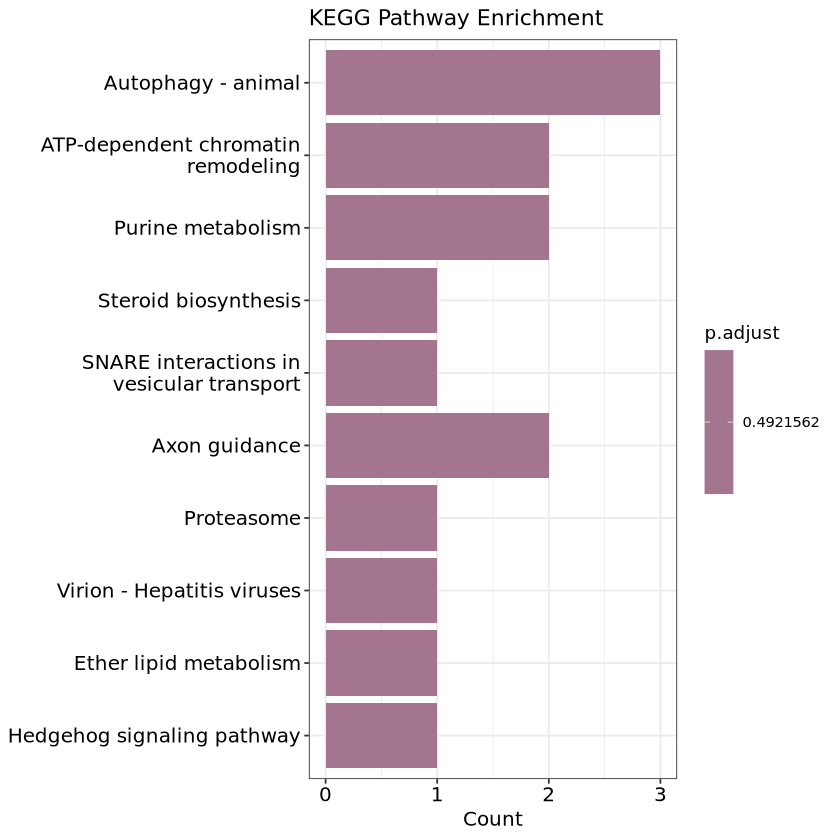

In [90]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")